# Predict the Subreddit

In [74]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import catboost as cb
from catboost import CatBoostClassifier
import shap

# NLP 
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

/Users/dunyaoguz/anaconda3/lib/python3.6/site-packages/shap/plots/colors.py:35: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  l_vals = list(np.linspace(blue_lch[0], l_mid, nsteps/2)) + list(np.linspace(l_mid, red_lch[0], nsteps/2))
/Users/dunyaoguz/anaconda3/lib/python3.6/site-packages/shap/plots/colors.py:35: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  l_vals = list(np.linspace(blue_lch[0], l_mid, nsteps/2)) + list(np.linspace(l_mid, red_lch[0], nsteps/2))


In [2]:
crazy_ideas = pd.read_csv('data/crazy_ideas.csv')
crazy_ideas_2 = pd.read_csv('data/crazy_ideas_2.csv')
shower_thoughts = pd.read_csv('data/shower_thoughts.csv')
shower_thoughts_2 = pd.read_csv('data/shower_thoughts_2.csv')

In [3]:
shower_thoughts.drop('Unnamed: 0', axis=1, inplace=True)
crazy_ideas.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
shower_thoughts = shower_thoughts.append(shower_thoughts_2, ignore_index=True)
crazy_ideas = crazy_ideas.append(crazy_ideas_2, ignore_index=True)

In [5]:
shower_thoughts.head()

,author,name,num_comments,permalink,score,selftext,stickied,subreddit,title,url
0,RamsesThePigeon,t3_bg71oh,63,/r/Showerthoughts/comments/bg71oh/your_essenti...,723,"The human brain is a decidedly odd machine, of...",True,Showerthoughts,Your Essential Guide to Showerthoughts,https://www.reddit.com/r/Showerthoughts/commen...
1,wcollins260,t3_bm8prf,469,/r/Showerthoughts/comments/bm8prf/some_guy_die...,17820,NaN,False,Showerthoughts,Some guy died running 26 miles and now people ...,https://www.reddit.com/r/Showerthoughts/commen...
2,rowanwoode,t3_bm4w9u,1404,/r/Showerthoughts/comments/bm4w9u/because_spid...,51196,"Also, earwigs can fly.",False,Showerthoughts,"Because spiders molt, every time you think you...",https://www.reddit.com/r/Showerthoughts/commen...
3,Alyeskas_ghost,t3_bm8f78,84,/r/Showerthoughts/comments/bm8f78/people_will_...,1340,NaN,False,Showerthoughts,"People will shave, wax, and bleach their genit...",https://www.reddit.com/r/Showerthoughts/commen...
4,CynicalSnow,t3_bm3854,197,/r/Showerthoughts/comments/bm3854/there_are_tw...,7015,NaN,False,Showerthoughts,There are two types of people who don't know w...,https://www.reddit.com/r/Showerthoughts/commen...


In [6]:
crazy_ideas.head()

,author,name,num_comments,permalink,score,selftext,stickied,subreddit,title,url
0,AddictedReddit,t3_854s2f,33,/r/CrazyIdeas/comments/854s2f/folks_be_sure_to...,212,This whole subreddit is becoming a politics ci...,True,CrazyIdeas,"Folks, be sure to read the sidebar. Especially...",https://www.reddit.com/r/CrazyIdeas/comments/8...
1,aiken_,t3_bm4krt,53,/r/CrazyIdeas/comments/bm4krt/an_international...,2090,NaN,False,CrazyIdeas,An international registry where you can indica...,https://www.reddit.com/r/CrazyIdeas/comments/b...
2,LogicalOptimist,t3_blqytz,85,/r/CrazyIdeas/comments/blqytz/when_your_online...,2795,Often I find myself a few dollars short of fre...,False,CrazyIdeas,When your online order is a few dollars short ...,https://www.reddit.com/r/CrazyIdeas/comments/b...
3,ImOwningThisUsername,t3_bm7tyt,2,/r/CrazyIdeas/comments/bm7tyt/mobilize_all_the...,10,We could then convince him to either be active...,False,CrazyIdeas,Mobilize all the influence of Reddit to find t...,https://www.reddit.com/r/CrazyIdeas/comments/b...
4,LoneKharnivore,t3_bm4g66,2,/r/CrazyIdeas/comments/bm4g66/profilespecific_...,24,Or whatever.,False,CrazyIdeas,Profile-specific filters for YouTube so I neve...,https://www.reddit.com/r/CrazyIdeas/comments/b...


In [7]:
df = shower_thoughts.append(crazy_ideas, ignore_index=True)
# get rid of potentially duplicated rows since there were two rounds of scraping
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(3432, 10)

In [9]:
df.isna().sum()

author             0
name               0
num_comments       0
permalink          0
score              0
selftext        2727
stickied           0
subreddit          0
title              0
url                0
dtype: int64

In [10]:
# remove a russian post
df.drop(df[df['title'].str.contains('пуленепробиваемые')].index[0], axis=0, inplace=True)

In [11]:
df.groupby('subreddit')['title'].count()

subreddit
CrazyIdeas        1562
Showerthoughts    1869
Name: title, dtype: int64

## EDA

1. Sentiment Analysis using [TextBlob](https://textblob.readthedocs.io/en/dev/).

In [12]:
df['polarity'] = df['title'].map(lambda text: TextBlob(text).sentiment.polarity)

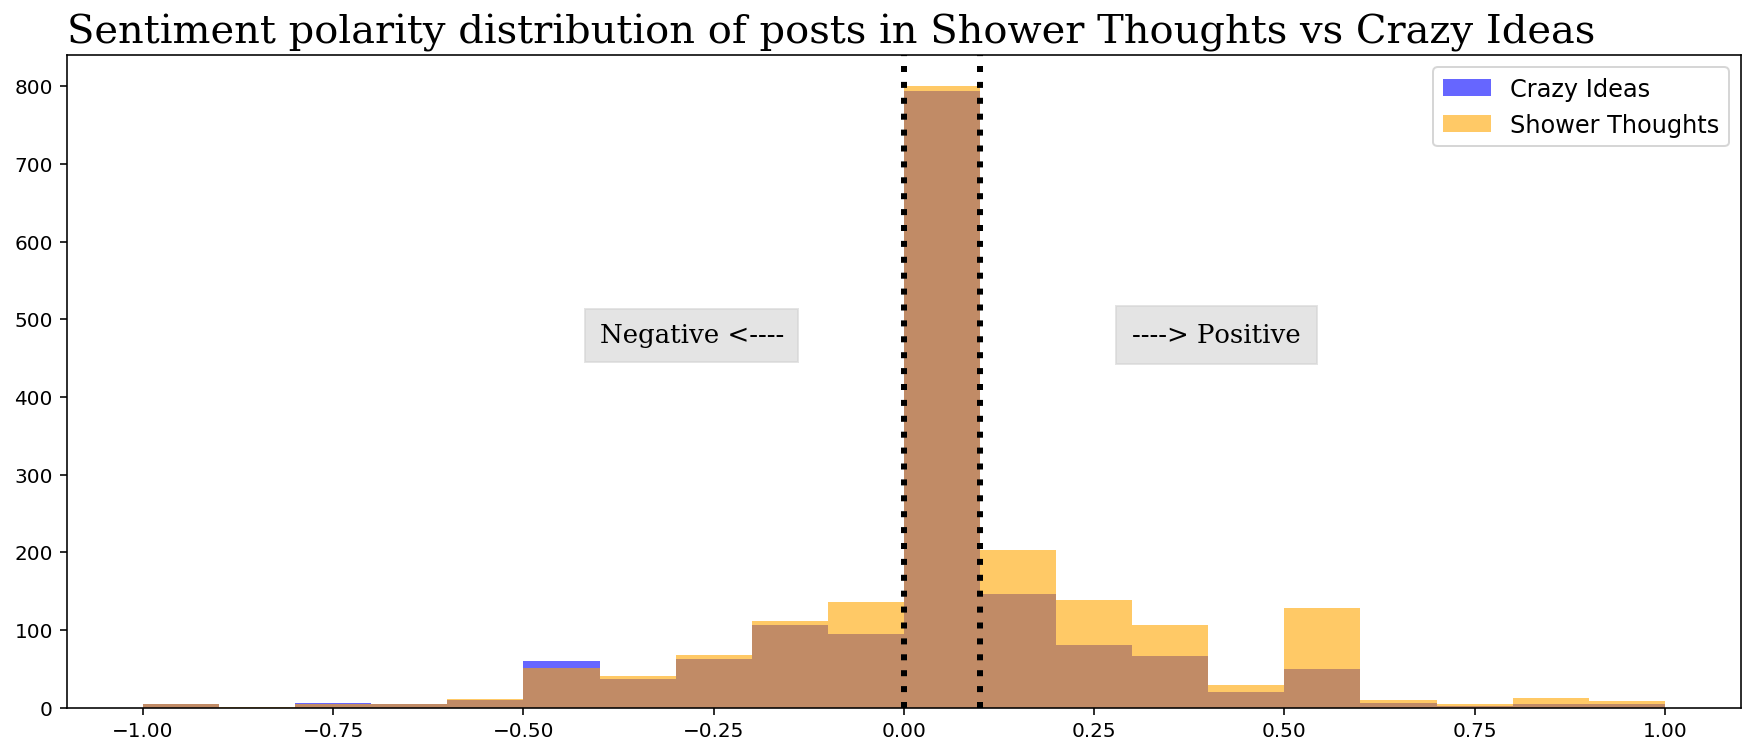

In [13]:
plt.figure(figsize=(15, 6))
plt.hist(df[df.subreddit == 'CrazyIdeas']['polarity'], bins=20, label='Crazy Ideas', alpha=0.6, color='blue');
plt.hist(df[df.subreddit == 'Showerthoughts']['polarity'], bins=20, label='Shower Thoughts', alpha=0.6, color='orange');
plt.title('Sentiment polarity distribution of posts in Shower Thoughts vs Crazy Ideas', fontsize=20, fontname='serif', loc='left')
plt.axvline(x=0.1, color='k', linewidth=3, linestyle=':')
plt.axvline(x=0, color='k', linewidth=3, linestyle=':')
plt.text(-0.40, 470, r'Negative <----', fontsize=13, fontname='serif', bbox={'color':'lightgrey', 'alpha': 0.6, 'pad': 7})
plt.text(0.30, 470, r'----> Positive', fontsize=13, fontname='serif', bbox={'color':'lightgrey', 'alpha': 0.6, 'pad': 8})
plt.legend(fontsize=12);

In [14]:
positive = df[df.polarity >= 0.5]['title'].sample(5).values
print('5 random reviews with positive sentiments: \n')
for i, p in enumerate(positive):
    print(str(i+1) + '. ' + p)

5 random reviews with positive sentiments: 

1. Our eyes reveal more about our temperament than our body language.
2. Movies ends with happy endings, if not they either have a sequel or they want to confuse people
3. If Tropic Thunder came out today, Robert Downey Jr. and the production staff would meet a lot more backlash (if they even got any backlash before).
4. Usain Bolt Will be the most effective zombie of all time.
5. We would benefit greatly if our brains could take a screenshot or video of exactly what we saw....


In [15]:
negative = df[df.polarity <= -0.5]['title'].sample(5).values
print('5 random reviews with negative sentiments: \n')
for i, n in enumerate(negative):
    print(str(i+1) + '. ' + n)

5 random reviews with negative sentiments: 

1. If you took a random person from anywhere in the world, there’s a thirty percent chance that there from either India or China.
2. Feed LSD to all the pigeons, birds and wildlife in a city The Pope is visiting: trick every one into thinking some weird miracle has occurred.
3. Make porn with 10 seconds of random music in the beginning so you can avoid 'accidents'...
4. “One Weird Trick” ads should be banned
5. Why Not Look Silly?


2. Title word count

In [16]:
df['word_count'] = df['title'].str.split().apply(len)

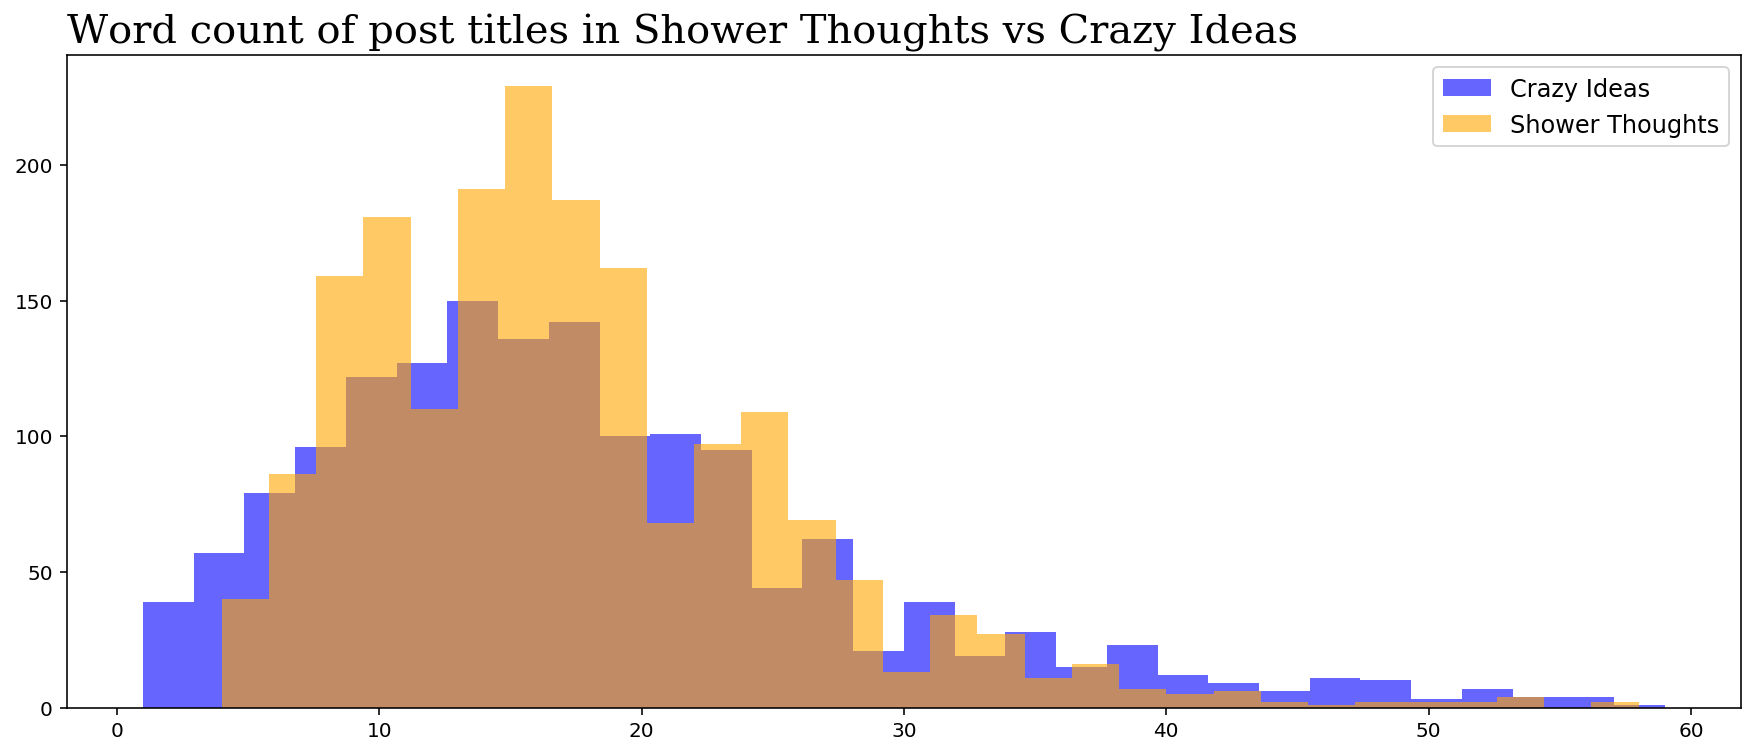

In [17]:
plt.figure(figsize=(15, 6))
plt.hist(df[df.subreddit == 'CrazyIdeas']['word_count'], bins=30, label='Crazy Ideas', alpha=0.6, color='blue');
plt.hist(df[df.subreddit == 'Showerthoughts']['word_count'], bins=30, label='Shower Thoughts', alpha=0.6, color='orange');
plt.title('Word count of post titles in Shower Thoughts vs Crazy Ideas', fontsize=20, fontname='serif', loc='left')
plt.legend(fontsize=12);

3. Top unigram and bigrams

In [18]:
stop = stopwords.words("english")
# add shower thoughts and crazy ideas to list of stop words since they give away the subreddit
stop.extend(['shower','thoughts', 'crazy', 'ideas', 've', 'is', 'was', 'like', 'don'])

In [19]:
# get unigrams
cvec = CountVectorizer(stop_words=stop)
uni = pd.DataFrame(cvec.fit_transform(df['title']).todense(), columns=cvec.get_feature_names())
uni['subreddit'] = df['subreddit']

shower_top_unigrams = uni.groupby('subreddit').sum().T.sort_values(by='Showerthoughts', ascending=False)[['Showerthoughts']].head(20)
crazy_top_unigrams = uni.groupby('subreddit').sum().T.sort_values(by='CrazyIdeas', ascending=False)[['CrazyIdeas']].head(20)

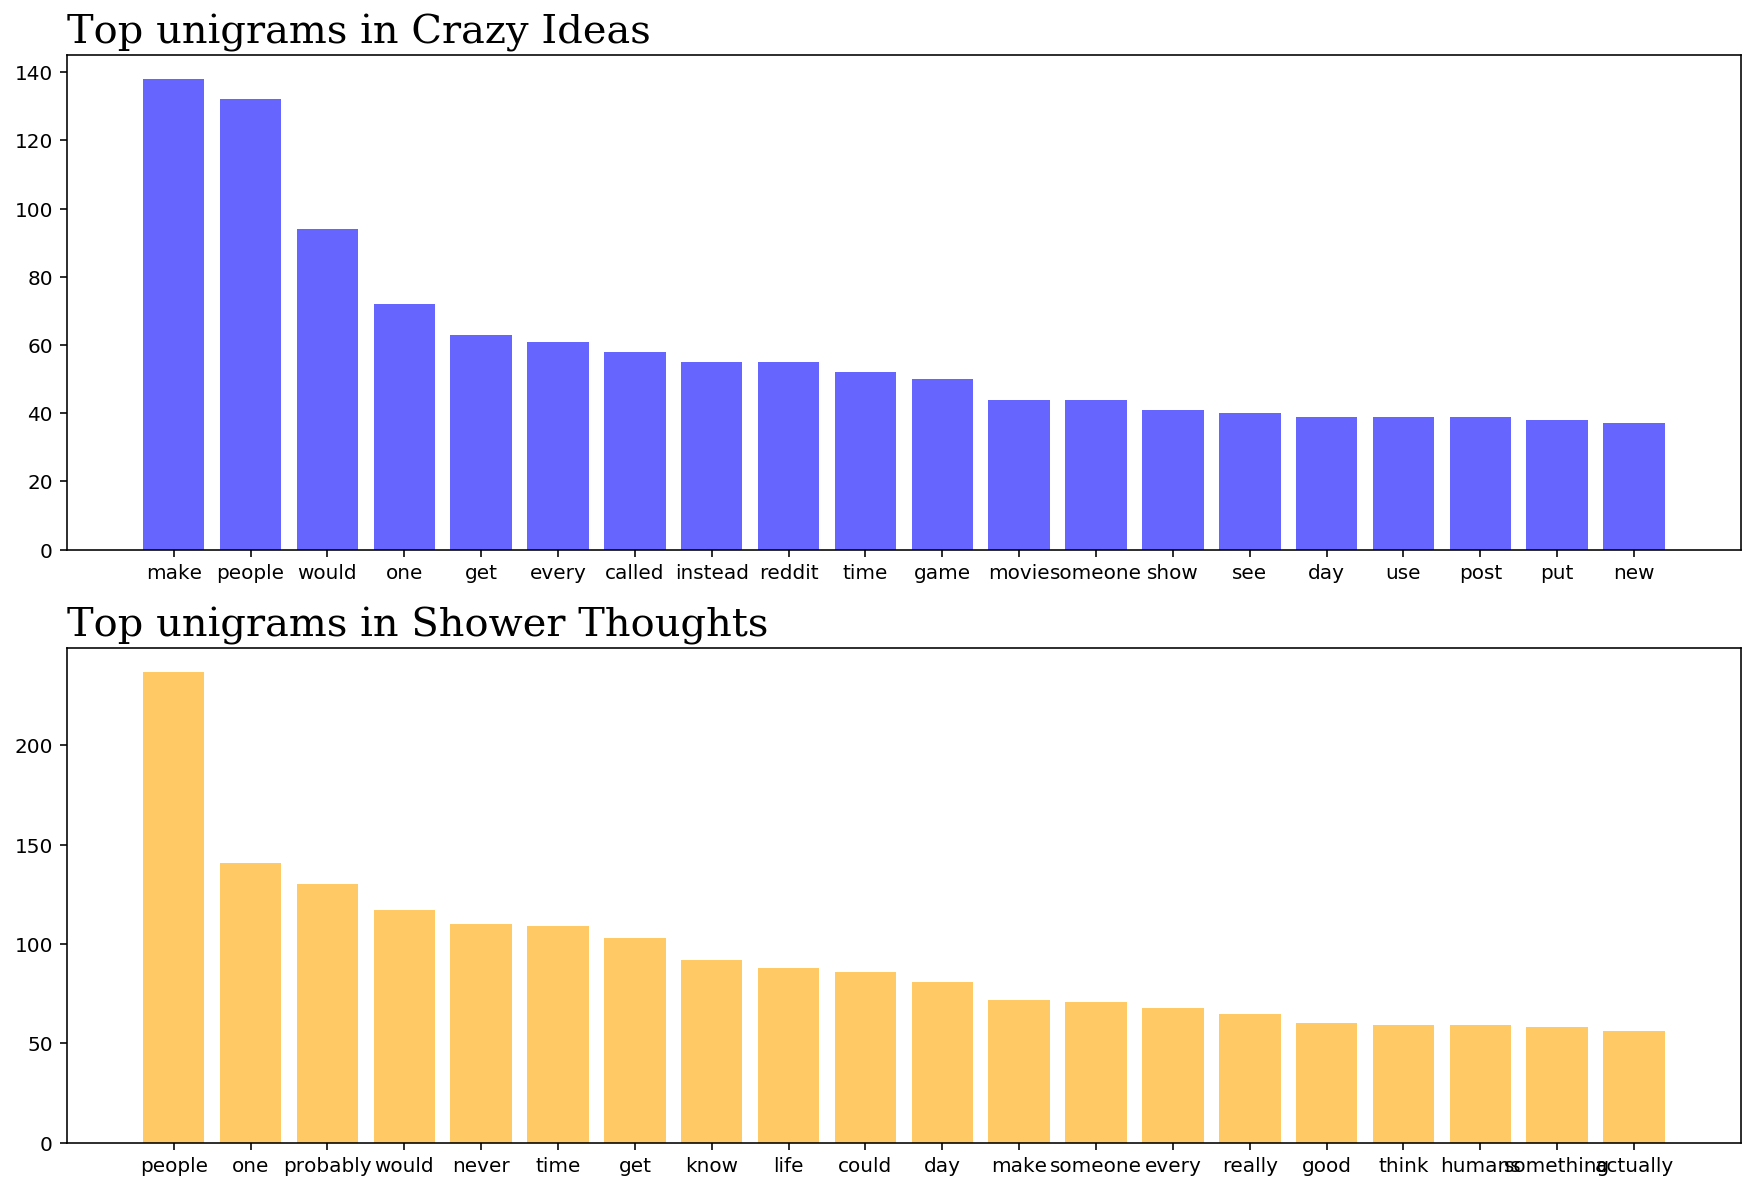

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

ax[0].bar(crazy_top_unigrams.index, crazy_top_unigrams.CrazyIdeas, alpha=0.6, color='blue');
ax[0].set_title('Top unigrams in Crazy Ideas', fontsize=20, fontname='serif', loc='left');

ax[1].bar(shower_top_unigrams.index, shower_top_unigrams.Showerthoughts, alpha=0.6, color='orange');
ax[1].set_title('Top unigrams in Shower Thoughts', fontsize=20, fontname='serif', loc='left');

In [21]:
# get bigrams
bivec = CountVectorizer(stop_words=stop, ngram_range=(2, 2))
bi = pd.DataFrame(bivec.fit_transform(df['title']).todense(), columns=bivec.get_feature_names())
bi['subreddit'] = df['subreddit']

shower_top_bigrams = bi.groupby('subreddit').sum().T.sort_values(by='Showerthoughts', ascending=False)[['Showerthoughts']].head(20)
crazy_top_bigrams = bi.groupby('subreddit').sum().T.sort_values(by='CrazyIdeas', ascending=False)[['CrazyIdeas']].head(20)

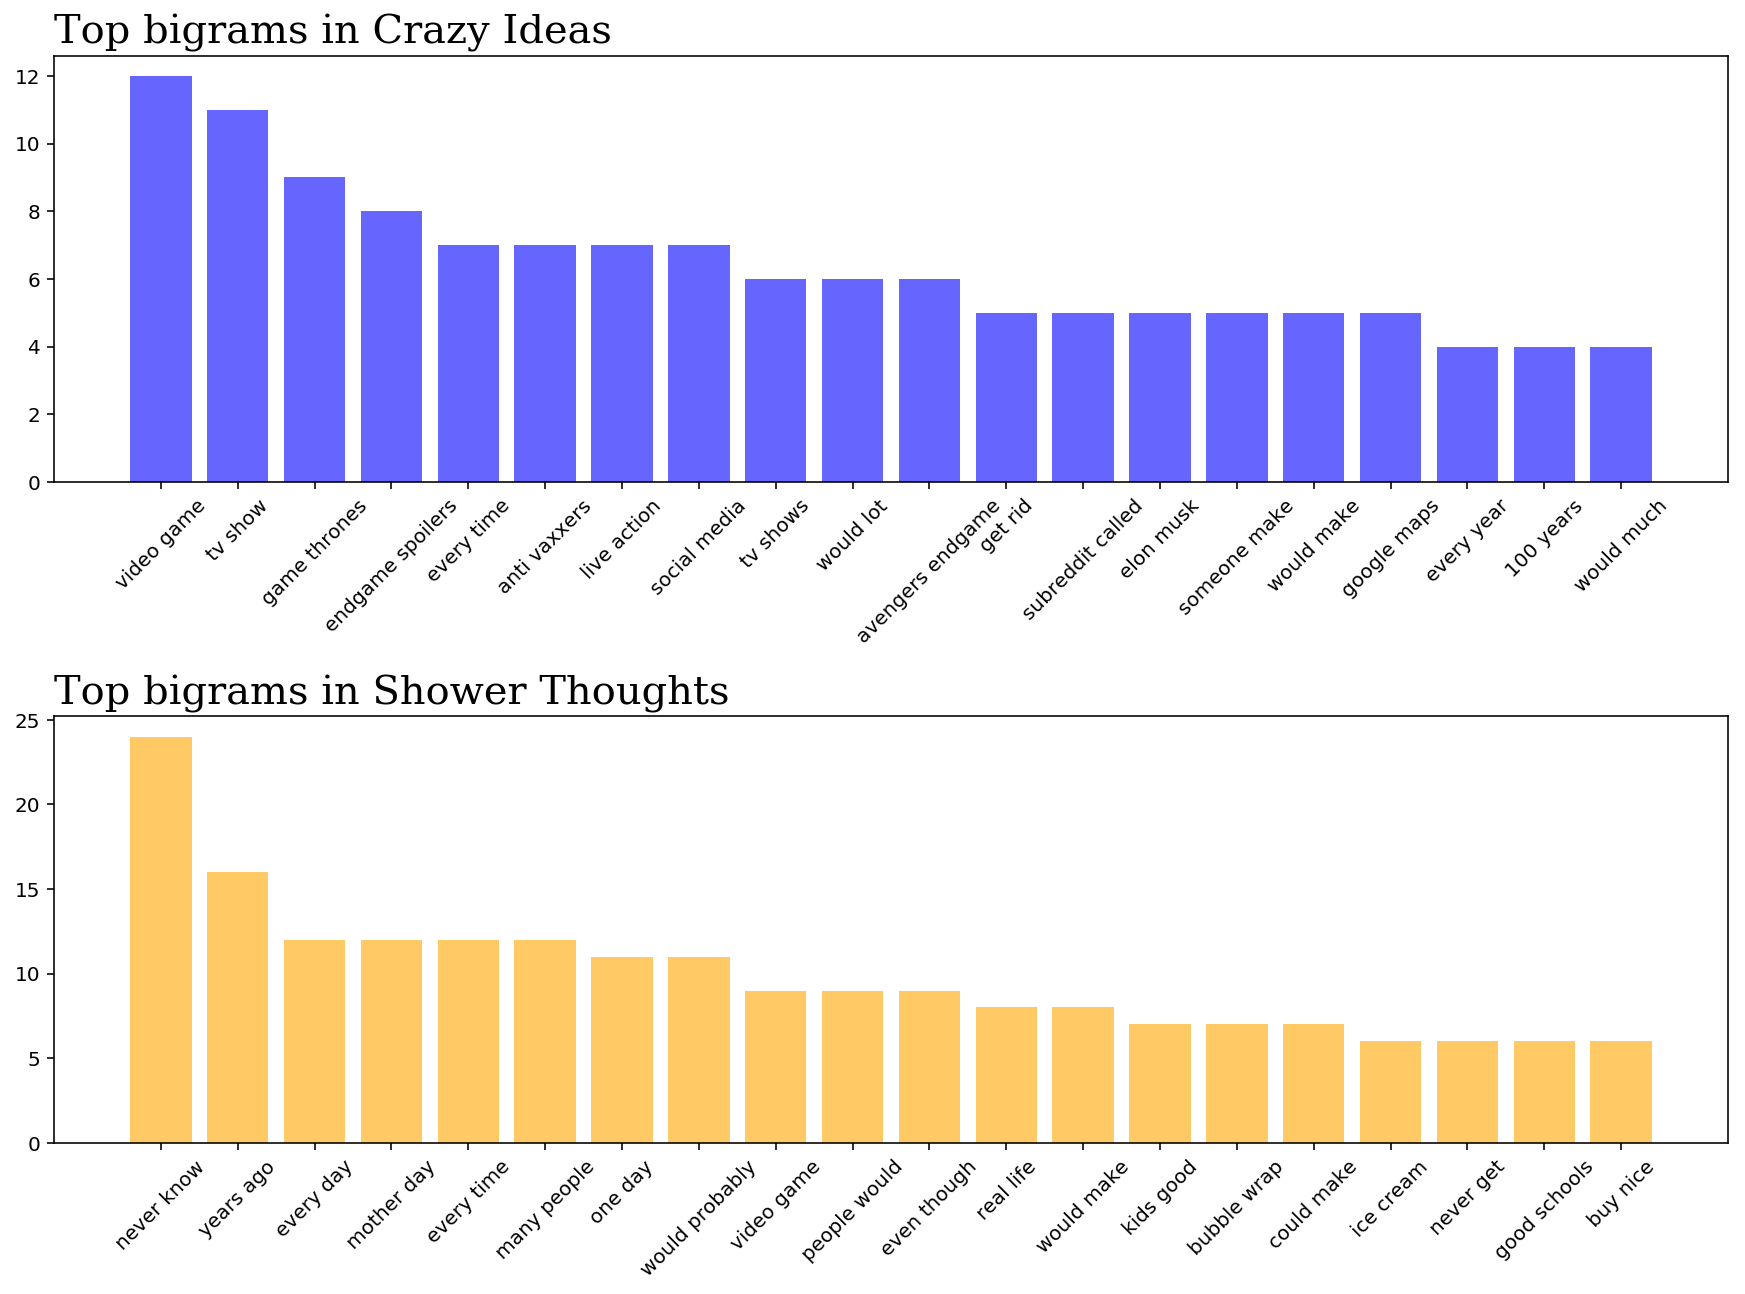

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

ax[0].bar(crazy_top_bigrams.index, crazy_top_bigrams.CrazyIdeas, alpha=0.6, color='blue');
ax[0].set_title('Top bigrams in Crazy Ideas', fontsize=20, fontname='serif', loc='left');
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45);

ax[1].bar(shower_top_bigrams.index, shower_top_bigrams.Showerthoughts, alpha=0.6, color='orange');
ax[1].set_title('Top bigrams in Shower Thoughts', fontsize=20, fontname='serif', loc='left');
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45);

plt.subplots_adjust(hspace=0.55)

4. Topic Modelling with Latent Dirichlet Allocation

In [23]:
shower_thoughts = df[df.subreddit == 'Showerthoughts']['title']
crazy_ideas = df[df.subreddit == 'CrazyIdeas']['title']

In [34]:
lda = LDA(n_components=3, random_state=42)
crazy_t = cvec.fit_transform(crazy_ideas)
lda_crazy = lda.fit_transform(crazy_t)
pyLDAvis.sklearn.prepare(lda, crazy_t, cvec)

/Users/dunyaoguz/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.019887 -0.110475       1        1  39.364976
0     -0.087840  0.072089       2        1  30.683923
2      0.107727  0.038387       3        1  29.951101, topic_info=     Category        Freq       Term       Total  loglift  logprob
3336  Default   37.000000       post   37.000000  30.0000  30.0000
4133  Default   38.000000    someone   38.000000  29.0000  29.0000
3181  Default  120.000000     people  120.000000  28.0000  28.0000
1564  Default   31.000000   everyone   31.000000  27.0000  27.0000
636   Default   19.000000       call   19.000000  26.0000  26.0000
400   Default   18.000000      based   18.000000  25.0000  25.0000
2726  Default   10.000000      metal   10.000000  24.0000  24.0000
90    Default   12.000000        add   12.000000  23.0000  23.0000
1149  Default   33.000000        day   33.000000  22.0000  22.0000
4847  Default   13.000000       vote   13.000000  21.0000  21.0000
1809  Default   22.000000       free   22.000000  20.0000  20.0000
1497  Default   16.000000    endgame   16.000000  19.0000  19.0000
1068  Default   28.000000     create   28.000000  18.0000  18.0000
4524  Default    8.000000    thrones    8.000000  17.0000  17.0000
754   Default    8.000000  character    8.000000  16.0000  16.0000
2     Default    8.000000        100    8.000000  15.0000  15.0000
1852  Default   40.000000       game   40.000000  14.0000  14.0000
2647  Default   10.000000       mars   10.000000  13.0000  13.0000
3924  Default   12.000000     series   12.000000  12.0000  12.0000
4999  Default   77.000000      would   77.000000  11.0000  11.0000
4823  Default   24.000000      video   24.000000  10.0000  10.0000
1904  Default   28.000000       give   28.000000   9.0000   9.0000
1722  Default   18.000000      first   18.000000   8.0000   8.0000
4757  Default   35.000000        use   35.000000   7.0000   7.0000
787   Default   10.000000      child   10.000000   6.0000   6.0000
358   Default   16.000000       back   16.000000   5.0000   5.0000
2845  Default   38.000000      movie   38.000000   4.0000   4.0000
2362  Default   16.000000      karma   16.000000   3.0000   3.0000
47    Default   21.000000       able   21.000000   2.0000   2.0000
4001  Default   23.000000      shows   23.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
1391   Topic3    4.741295      drunk    5.929310   0.9820  -6.8827
4001   Topic3   14.622933      shows   23.175035   0.7451  -5.7564
1852   Topic3   21.428147       game   40.645766   0.5654  -5.3743
2845   Topic3   20.264796      movie   38.083764   0.5747  -5.4301
1722   Topic3   11.321770      first   18.039062   0.7398  -6.0123
4757   Topic3   18.579499        use   35.773825   0.5504  -5.5169
4999   Topic3   31.296944      would   77.040273   0.3048  -4.9955
2615   Topic3   39.292608       make  120.489012   0.0851  -4.7679
1564   Topic3   15.226599   everyone   31.025183   0.4938  -5.7159
2932   Topic3   16.388920        new   35.127524   0.4432  -5.6424
4542   Topic3   19.037243       time   46.906668   0.3038  -5.4926
3552   Topic3    9.173087       real   15.818681   0.6607  -6.2227
1561   Topic3   19.751674      every   52.046723   0.2367  -5.4557
2865   Topic3   12.631734      music   26.337986   0.4708  -5.9028
2854   Topic3   10.561486       much   20.068945   0.5636  -6.0818
2810   Topic3   10.782700      money   20.967148   0.5406  -6.0610
1886   Topic3    8.420883       gets   14.305374   0.6757  -6.3083
4823   Topic3   10.786312      video   24.265339   0.3948  -6.0607
4874   Topic3   10.452814       want   23.168667   0.4097  -6.0921
3586   Topic3   14.138755     reddit   50.969595  -0.0767  -5.7901
1884   Topic3   15.055626        get   59.880571  -0.1750  -5.7272
1551   Topic3    8.436262        etc   14.881279   0.6380  -6.3064
2263   Topic3   13.178078    instead   47.950835  -0.0860  -5.8604
48

In [35]:
shower_t = cvec.fit_transform(shower_thoughts)
lda_shower = lda.fit_transform(shower_t)
pyLDAvis.sklearn.prepare(lda, shower_t, cvec)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.079447  0.079889       1        1  39.633748
0     -0.114841  0.023425       2        1  31.885285
1      0.035394 -0.103314       3        1  28.480967, topic_info=     Category       Freq      Term       Total  loglift  logprob
2088  Default  42.000000     human   42.000000  30.0000  30.0000
4818  Default  92.000000     would   92.000000  29.0000  29.0000
1495  Default  36.000000      even   36.000000  28.0000  28.0000
3681  Default  25.000000    saying   25.000000  27.0000  27.0000
4695  Default  27.000000     water   27.000000  26.0000  26.0000
2482  Default  28.000000      look   28.000000  25.0000  25.0000
132   Default  43.000000  actually   43.000000  24.0000  24.0000
1810  Default  28.000000    future   28.000000  23.0000  23.0000
4842  Default  43.000000     years   43.000000  22.0000  22.0000
1959  Default  15.000000      half   15.000000  21.0000  21.0000
2343  Default  76.000000      know   76.000000  20.0000  20.0000
1892  Default  47.000000      good   47.000000  19.0000  19.0000
2319  Default  35.000000      kids   35.000000  18.0000  18.0000
0     Default  11.000000       000   11.000000  17.0000  17.0000
212   Default  40.000000    always   40.000000  16.0000  16.0000
1277  Default  28.000000      dogs   28.000000  15.0000  15.0000
2768  Default  31.000000      much   31.000000  14.0000  14.0000
2092  Default  46.000000    humans   46.000000  13.0000  13.0000
2762  Default  18.000000     movie   18.000000  12.0000  12.0000
4324  Default  22.000000     thing   22.000000  11.0000  11.0000
1004  Default  68.000000     could   68.000000  10.0000  10.0000
2529  Default  55.000000      make   55.000000   9.0000   9.0000
1567  Default   9.000000      face    9.000000   8.0000   8.0000
3161  Default  19.000000   playing   19.000000   7.0000   7.0000
1853  Default  77.000000       get   77.000000   6.0000   6.0000
2784  Default  29.000000      must   29.000000   5.0000   5.0000
4673  Default  23.000000      want   23.000000   4.0000   4.0000
4574  Default  17.000000     using   17.000000   3.0000   3.0000
881   Default  10.000000     comes   10.000000   2.0000   2.0000
2036  Default  18.000000   history   18.000000   1.0000   1.0000
...       ...        ...       ...         ...      ...      ...
3034   Topic3   8.194926      past   10.631411   0.9956  -6.3702
212    Topic3  24.221159    always   40.611311   0.7391  -5.2865
2762   Topic3  12.368390     movie   18.223221   0.8684  -5.9586
4574   Topic3  11.652049     using   17.675014   0.8393  -6.0183
4615   Topic3  10.596886     video   16.045308   0.8411  -6.1132
4215   Topic3   7.780170    system   10.626041   0.9442  -6.4222
3268   Topic3  37.260894  probably  102.980702   0.2393  -4.8558
3733   Topic3   9.832681      seen   15.384404   0.8083  -6.1880
2768   Topic3  15.408018      much   31.789315   0.5317  -5.7388
4361   Topic3  29.427495      time   86.306651   0.1800  -5.0918
3946   Topic3  22.397498   someone   58.246783   0.3002  -5.3648
3072   Topic3  44.203783    people  184.634708  -0.1736  -4.6849
1853   Topic3  25.036466       get   77.650340   0.1241  -5.2534
4802   Topic3  11.506649      word   21.664428   0.6232  -6.0308
4325   Topic3  16.848518    things   42.993449   0.3191  -5.6495
1653   Topic3  11.101505      find   20.773621   0.6293  -6.0667
2498   Topic3  14.976533       lot   37.880917   0.3280  -5.7673
2780   Topic3   8.470647     music   13.068298   0.8224  -6.3371
2092   Topic3  15.180712    humans   46.754621   0.1310  -5.7537
2830   Topic3  19.826222     never   85.629390  -0.2071  -5.4867
4818   Topic3  19.918416     would   92.052728  -0.2748  -5.4821
1817   Topic3  12.994195      game   33.825941   0.2992  -5.9092
4324   Topic3  10.773809     thing   22.076363   0.5385  -6.0966
1892   Topic3  14.112520      good   47.771040   0.0366  -5.8267
1855   Topic3  10.827022   getting   22.462555 

## Naive Model

In [23]:
X = df['title']
lb = LabelEncoder()
y = lb.fit_transform(df['subreddit'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [24]:
# A Simple Bag of Words Model
X_train_counts = cvec.fit_transform(X_train)
X_test_counts = cvec.transform(X_test)

In [25]:
df_counts = pd.DataFrame(X_train_counts.todense(), columns=cvec.get_feature_names())
df_counts.head()

,000,09,10,100,1000,10000,10m,10x10,11,11th,...,zombie,zombies,zone,zones,zoo,zoom,zoos,αmerica,оppоsite,оther
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_counts, y_train)
print(f'Train score: {model.score(X_train_counts, y_train)}')
print(f'Test score: {model.score(X_test_counts, y_test)}')

Train score: 0.9916180758017493
Test score: 0.826783114992722


In [27]:
y_pred = model.predict(X_test_counts)

def classification_metrics(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f'Precision: {round(tp/(tp+fp), 2)}')
    print(f'Sensitivity: {round(tp/(tp+fn), 2)}')
    print(f'Specificity: {round(tn/(tn+fp), 2)}')
    
classification_metrics(y_test, y_pred)

Precision: 0.83
Sensitivity: 0.88
Specificity: 0.76


## Better Model

The simplest model we can build gives an accuracy of 82.6%. Let's try to beat this using more advanced NLP methods and classification algorithms. 

### Engineer new features
1. Use document embeddings as a feature with [gensim Doc2Vec](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb)
2. Use word counts as a feature
3. Lemmatize words
4. Tokenize words using TfidfVectorizer
5. Include bigrams of words

In [28]:
corpus = []
tokenizer = RegexpTokenizer(r'\w\w+') # drop punctuation

for title in df['title']:
    token = tokenizer.tokenize(title.lower())
    corpus.append(token)

In [29]:
# get document embeddings of size-1
documents = [TaggedDocument(doc, [sub]) for doc, sub in zip(corpus, df['subreddit'])]
model = Doc2Vec(documents, vector_size=1, window=2, min_count=1, workers=4, epochs=20)
doc2vec = []

for c in corpus:
    doc2vec.append(model.infer_vector(c)[0])
    
df['doc2vec_vector'] = doc2vec

In [30]:
def check_pos_tag(sentence, word):
    pos_tagged_sentence = pos_tag(sentence)
    words = [_[0] for _ in pos_tagged_sentence]
    pos_tags = [_[1] for _ in pos_tagged_sentence]
    for i, w in enumerate(words):
        if w == word:
            if pos_tags[i].startswith('J'):
                return wordnet.ADJ
            elif pos_tags[i].startswith('V'):
                return wordnet.VERB
            elif pos_tags[i].startswith('N'):
                return wordnet.NOUN
            elif pos_tags[i].startswith('R'):
                return wordnet.ADV
            else:
                return None

In [31]:
# lemmatize words
lemmatizer = WordNetLemmatizer()
lemmatized_corpus = []
for doc in corpus:
    lemmatized_doc = []
    for word in doc:
        pos = check_pos_tag(doc, word)
        if pos:
            lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
        else:
            lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_doc.append(lemmatized_word)
    lemmatized_doc = ' '.join(lemmatized_doc)
    lemmatized_corpus.append(lemmatized_doc)

In [32]:
lemmatized_corpus[60:70]

['when you die imagine wake up couple century later revive by their current technology that we can even imagine yet',
 'when you leave for work every day you dog probably think you be go to the dog park pet store on walk the beach etc all day because that what they know of the outside world',
 'we use to pick up the phone wondering who call now we refuse to pick up the phone because we don know who call',
 'ice cream never get stick in your teeth',
 'someone probably saw one of your text message while they be masturbate',
 'we may all be see different color but all teach the same word',
 'we nod down to acknowledge stranger but we nod up if we see somebody we know expose our throat',
 'noobmaster69 abuse others on mic while play fortnite be the most accurate depiction of teenager in cinema history',
 'tetri be great preparation for deal with an office fridge',
 'ask for friend be the least believed sentence in the entire history of humanity']

In [33]:
df['title'] = lemmatized_corpus

In [34]:
mms = MinMaxScaler()
df['word_count'] = mms.fit_transform(df[['word_count']])

/Users/dunyaoguz/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [55]:
# make doc2vec values positive, as negative values can not be passed onto multinomial bayes classifier
df['doc2vec_vector'] = df['doc2vec_vector'] ** 2
df['doc2vec_vector'] = mms.fit_transform(df[['doc2vec_vector']])

In [56]:
# option 1: tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))
tfidf_corpus = tfidf.fit_transform(df['title'])
tfidf_df = pd.DataFrame(tfidf_corpus.todense(), columns=tfidf.get_feature_names())

X_tfidf = pd.concat([df[['word_count', 'doc2vec_vector']].reset_index().drop('index', axis=1), tfidf_df], axis=1)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, random_state=42, test_size=0.2)

In [57]:
# option 2: count vectorizer
cvec = CountVectorizer(stop_words=stop, ngram_range=(1, 2))
cvec_corpus = cvec.fit_transform(df['title'])
cvec_df = pd.DataFrame(cvec_corpus.todense(), columns=cvec.get_feature_names())

X_cvec = pd.concat([df[['word_count', 'doc2vec_vector']].reset_index().drop('index', axis=1), cvec_df], axis=1)
X_train_cvec, X_test_cvec, y_train_cvec, y_test_cvec = train_test_split(X_cvec, y, random_state=42, test_size=0.2)

#### Test different algorithms
1. Logistic Regression
2. Random Forest Classifier
3. Naive Bayes
4. CatBoost

In [58]:
# create a convenience functions to assess classification algorithms
def fit_and_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print(f'Train score: {model.score(X_train, y_train)}')
    print(f'Test score: {model.score(X_test, y_test)}')

def plot_roc_curve(model, X_test, y_test): 
    tpr_values = []
    fpr_values = []
    
    for cutoff in np.linspace(0,1,200):
        y_pred = np.where([_[1] for _ in model.predict_proba(X_test)] >= cutoff, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp+fn)
        specificity = tn / (tn+fp)
        tpr_values.append(sensitivity)
        fpr_values.append(1 - specificity)
        
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr_values, tpr_values, label='ROC Curve')
    plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='baseline', linestyle='--')
    plt.title(f'ROC Curve, AUC = {round(auc, 2)}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)
    plt.legend(fontsize=16);

TFIDF
----------------------------------------------------------------------
Train score: 0.9806851311953353
Test score: 0.7962154294032023

Count Vectorizer
----------------------------------------------------------------------
Train score: 0.999271137026239
Test score: 0.8311499272197962


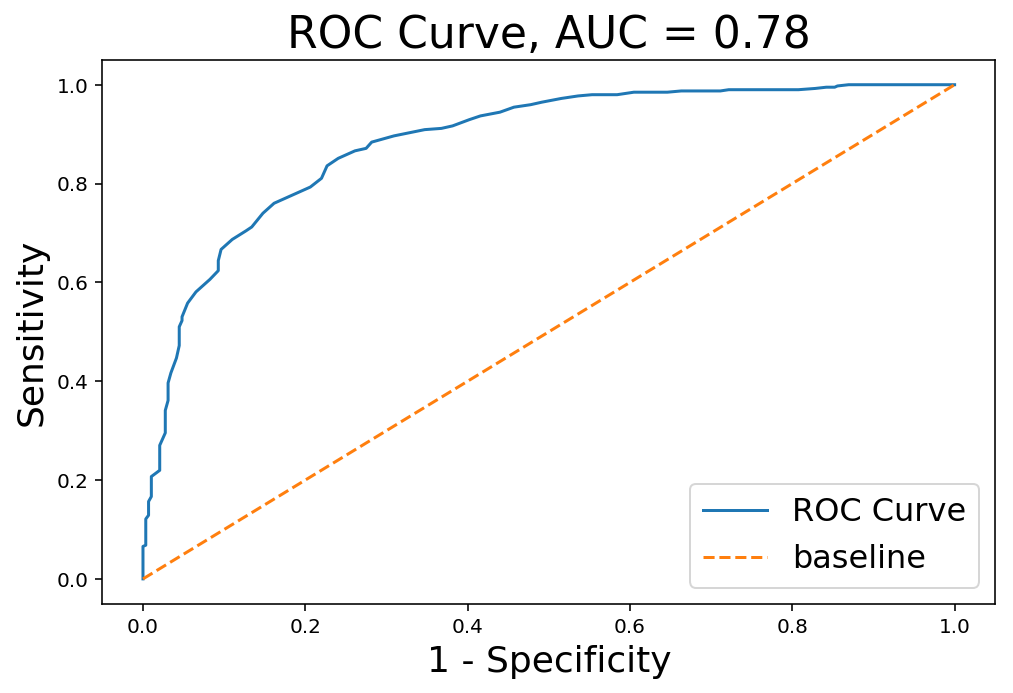

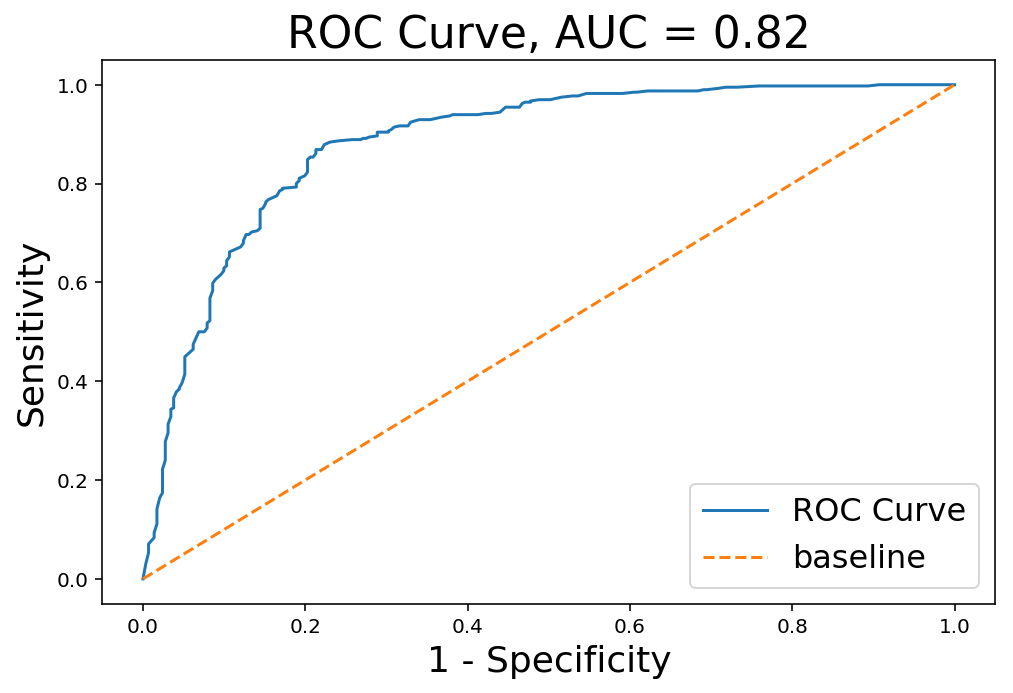

In [59]:
model = LogisticRegression(solver='lbfgs')
print('TFIDF')
print('----------------------------------------------------------------------')
fit_and_score(model, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
plot_roc_curve(model, X_test_tfidf, y_test_tfidf)
print('')
print('Count Vectorizer')
print('----------------------------------------------------------------------')
fit_and_score(model, X_train_cvec, y_train_cvec, X_test_cvec, y_test_cvec)
plot_roc_curve(model, X_test_cvec, y_test_cvec)

TFIDF
----------------------------------------------------------------------
Train score: 0.9996355685131195
Test score: 0.8136826783114993

Count Vectorizer
----------------------------------------------------------------------
Train score: 0.9996355685131195
Test score: 0.8165938864628821


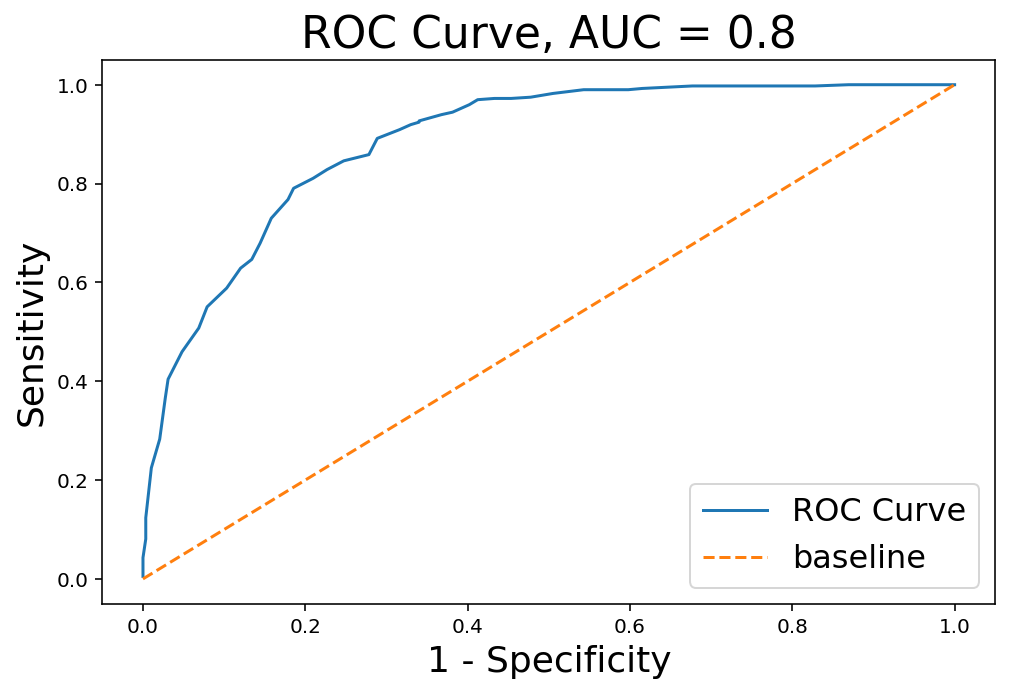

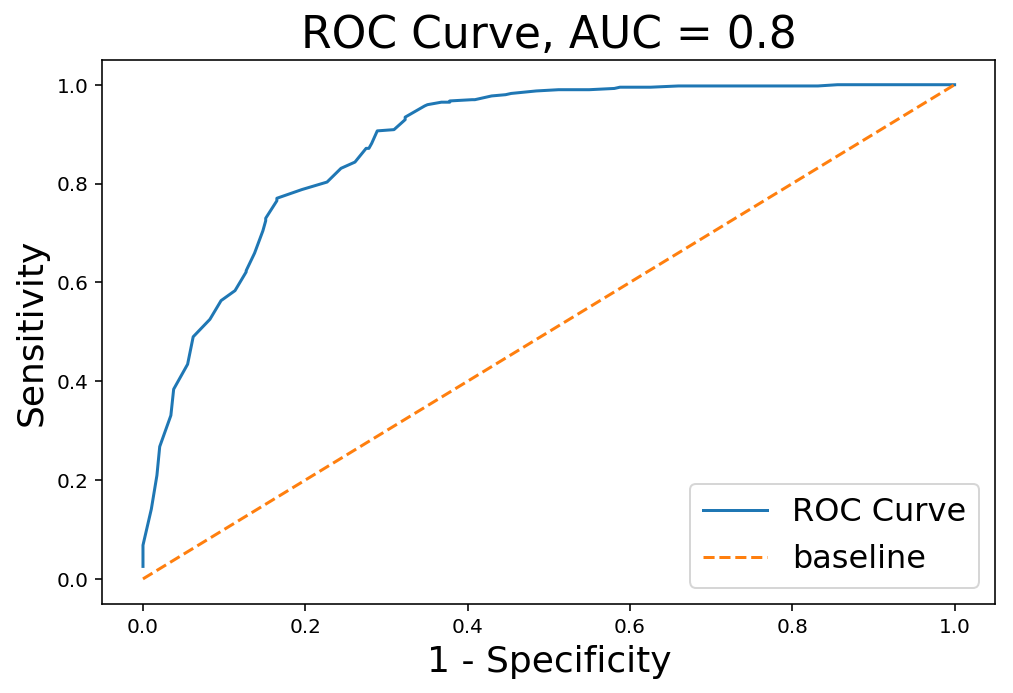

In [60]:
forest = RandomForestClassifier(n_estimators=50)
print('TFIDF')
print('----------------------------------------------------------------------')
fit_and_score(forest, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
plot_roc_curve(forest, X_test_tfidf, y_test_tfidf)
print('')
print('Count Vectorizer')
print('----------------------------------------------------------------------')
fit_and_score(forest, X_train_cvec, y_train_cvec, X_test_cvec, y_test_cvec)
plot_roc_curve(forest, X_test_cvec, y_test_cvec)

TFIDF
----------------------------------------------------------------------
Train score: 0.967201166180758
Test score: 0.7656477438136827

Count Vectorizer
----------------------------------------------------------------------
Train score: 0.9876093294460642
Test score: 0.8282387190684134


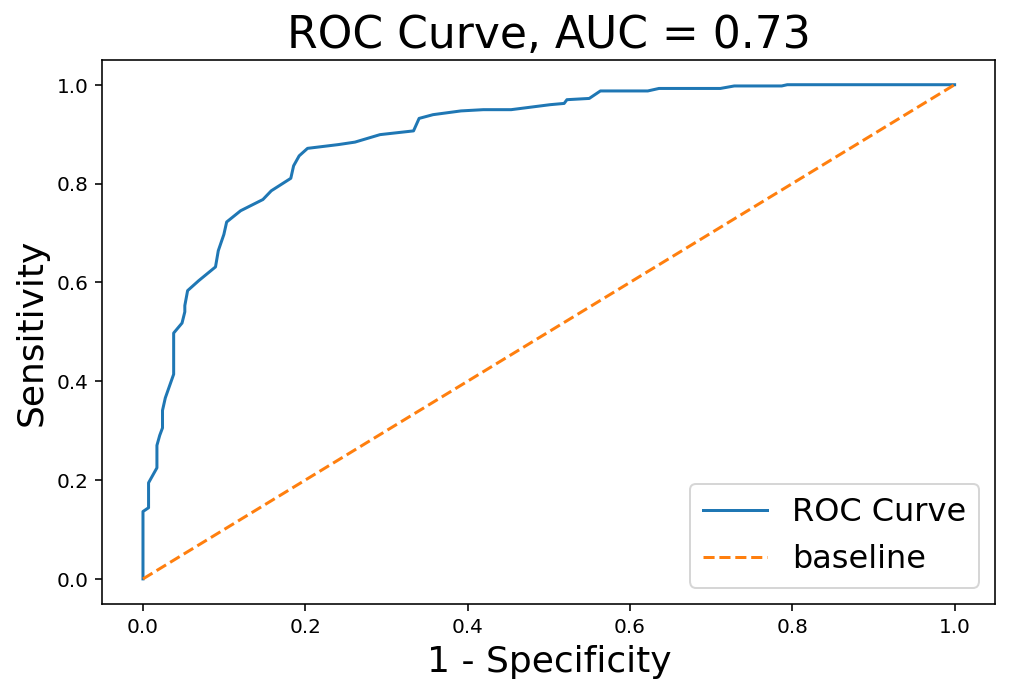

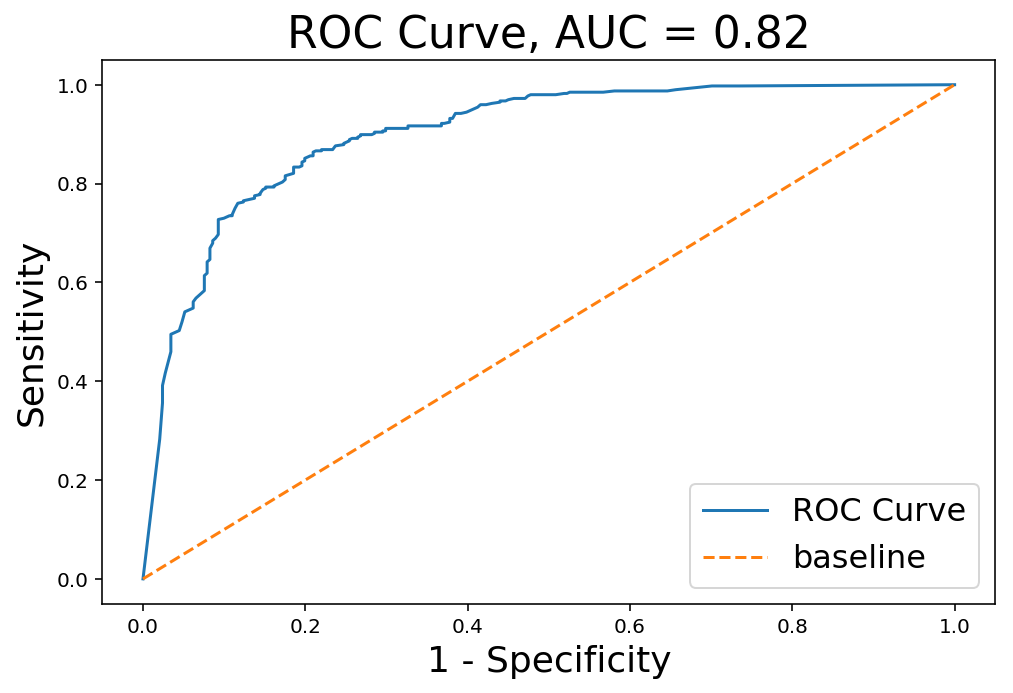

In [70]:
bayes = MultinomialNB(alpha=2)
print('TFIDF')
print('----------------------------------------------------------------------')
fit_and_score(bayes, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
plot_roc_curve(bayes, X_test_tfidf, y_test_tfidf)
print('')
print('Count Vectorizer')
print('----------------------------------------------------------------------')
fit_and_score(bayes, X_train_cvec, y_train_cvec, X_test_cvec, y_test_cvec)
plot_roc_curve(bayes, X_test_cvec, y_test_cvec)

In [76]:
cb = CatBoostClassifier(iterations=100, learning_rate=0.5, early_stopping_rounds=20, loss_function = 'Logloss', custom_metric='Accuracy')
print('TFIDF')
print('----------------------------------------------------------------------')
cb.fit(X_train_tfidf, y_train_tfidf, eval_set=(X_test_tfidf, y_test_tfidf), plot=True)

TFIDF
----------------------------------------------------------------------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6571050	test: 0.6643961	best: 0.6643961 (0)	total: 238ms	remaining: 23.5s
1:	learn: 0.6275377	test: 0.6342698	best: 0.6342698 (1)	total: 401ms	remaining: 19.7s
2:	learn: 0.6112025	test: 0.6237060	best: 0.6237060 (2)	total: 627ms	remaining: 20.3s
3:	learn: 0.5995643	test: 0.6140881	best: 0.6140881 (3)	total: 818ms	remaining: 19.6s
4:	learn: 0.5927797	test: 0.6058555	best: 0.6058555 (4)	total: 1s	remaining: 19.1s
5:	learn: 0.5819161	test: 0.6064435	best: 0.6058555 (4)	total: 1.22s	remaining: 19.1s
6:	learn: 0.5734259	test: 0.5963041	best: 0.5963041 (6)	total: 1.48s	remaining: 19.7s
7:	learn: 0.5731253	test: 0.5960772	best: 0.5960772 (7)	total: 1.64s	remaining: 18.9s
8:	learn: 0.5728921	test: 0.5960684	best: 0.5960684 (8)	total: 1.91s	remaining: 19.3s
9:	learn: 0.5651530	test: 0.5967025	best: 0.5960684 (8)	total: 2.14s	remaining: 19.2s
10:	learn: 0.5631456	test: 0.5952994	best: 0.5952994 (10)	total: 2.32s	remaining: 18.8s
11:	learn: 0.5550453	test: 0.5929240	best: 0.5929240 (1

In [77]:
print('Count Vectorizer')
print('----------------------------------------------------------------------')
cb.fit(X_train_cvec, y_train_cvec, eval_set=(X_test_cvec, y_test_cvec), plot=True)

Count Vectorizer
----------------------------------------------------------------------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6753857	test: 0.6744315	best: 0.6744315 (0)	total: 199ms	remaining: 19.7s
1:	learn: 0.6457639	test: 0.6462017	best: 0.6462017 (1)	total: 462ms	remaining: 22.6s
2:	learn: 0.6212723	test: 0.6192051	best: 0.6192051 (2)	total: 761ms	remaining: 24.6s
3:	learn: 0.6133916	test: 0.6127132	best: 0.6127132 (3)	total: 1.21s	remaining: 29.1s
4:	learn: 0.6031109	test: 0.6068083	best: 0.6068083 (4)	total: 1.5s	remaining: 28.4s
5:	learn: 0.5982780	test: 0.6016484	best: 0.6016484 (5)	total: 1.74s	remaining: 27.3s
6:	learn: 0.5923516	test: 0.5938110	best: 0.5938110 (6)	total: 1.98s	remaining: 26.3s
7:	learn: 0.5842021	test: 0.5891001	best: 0.5891001 (7)	total: 2.21s	remaining: 25.4s
8:	learn: 0.5790713	test: 0.5874322	best: 0.5874322 (8)	total: 2.31s	remaining: 23.4s
9:	learn: 0.5745254	test: 0.5820527	best: 0.5820527 (9)	total: 2.51s	remaining: 22.6s
10:	learn: 0.5668023	test: 0.5812691	best: 0.5812691 (10)	total: 2.71s	remaining: 21.9s
11:	learn: 0.5604702	test: 0.5764664	best: 0.5764664 

94:	learn: 0.3016524	test: 0.4822905	best: 0.4821012 (92)	total: 22.8s	remaining: 1.2s
95:	learn: 0.3010419	test: 0.4834101	best: 0.4821012 (92)	total: 23.1s	remaining: 961ms
96:	learn: 0.3007496	test: 0.4832063	best: 0.4821012 (92)	total: 23.3s	remaining: 721ms
97:	learn: 0.2995692	test: 0.4827189	best: 0.4821012 (92)	total: 23.6s	remaining: 481ms
98:	learn: 0.2982377	test: 0.4831339	best: 0.4821012 (92)	total: 23.7s	remaining: 240ms
99:	learn: 0.2977073	test: 0.4829152	best: 0.4821012 (92)	total: 23.9s	remaining: 0us

bestTest = 0.4821012166
bestIteration = 92

Shrink model to first 93 iterations.
